In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import rotate

### Plot Style

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
BIGGEST_SIZE = 25

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Compile Data

Data is located in accompanying data folder. The naming indicates whether we were measuring the sine or cosine information of the Fourier Transform, the quadrant the push was performed in, and how long the y-mode push was performed for.  For example, sine_plus_plus_y=30 indicates measuring the sine information (starting in the $\sigma_y$ eigenstate) in the positive x, positive y quadrant and with a 30 $\mu$s push.  This push time is later converted to k-vector via the appropriate Rabi frequency. The data in file is from an x-mode push scan, going up to 120 $\mu$s.  The x-mode Rabi frequency is about 1.8 times faster than that of the y-mode, hence the shorter push time.

Only the first 12 data points are taken since the final data point often failed on our software.  This avoids ragged arrays.  The final data point is the furthest along in the spin-dependent push as well, meaning it would be the furthest from the important features.  We also choose to use the zero point from the negative side of the data.  This is found to make very little difference to the final distribution. 

In [3]:
def importData1(fname):
    timeTickFirst, timeTickLast, x, \
    ion1, ion1_raw, ion1_bottom, ion1_top, \
    ion2, ion2_raw, ion2_bottom, ion2_top = np.genfromtxt(fname, delimiter="\t",comments="#", unpack="True", encoding='latin1')
    return x, ion1, ion2

In [4]:
sft = list()
nsft = list()
cft = list()
ncft = list()


# +- sine 
for n in range(11, -1, -1):
    x, ion1, ion2 = importData1(f'data/sine_plus_minus_y={15*n}')
    sft.append(ion2[:12])

# ++ sine 
for n in range(1, 12, 1):
    x, ion1, ion2 = importData1(f'data/sine_plus_plus_y={15*n}')
    sft.append(ion2[:12])

# -- sine 
for n in range(11, -1, -1):
    x, ion1, ion2 = importData1(f'data/sine_minus_minus_y={15*n}')
    nsft.append(ion2[:12])

# -+ sine 
for n in range(1, 12, 1):
    x, ion1, ion2 = importData1(f'data/sine_minus_plus_y={15*n}')
    nsft.append(ion2[:12])

# +- cosine 
for n in range(11, -1, -1):
    x, ion1, ion2 = importData1(f'data/cosine_plus_minus_y={15*n}')
    cft.append(ion2[:12])

# ++ cosine 
for n in range(1, 12, 1):
    x, ion1, ion2 = importData1(f'data/cosine_plus_plus_y={15*n}')
    cft.append(ion2[:12])

# -- cosine 
for n in range(11, -1, -1):
    x, ion1, ion2 = importData1(f'data/cosine_minus_minus_y={15*n}')
    ncft.append(ion2[:12])

# -+ cosine 
for n in range(1, 12, 1):
    x, ion1, ion2 = importData1(f'data/cosine_minus_plus_y={15*n}')
    ncft.append(ion2[:12])
    
sft = np.array(sft)
nsft = np.array(nsft)
cft = np.array(cft)
ncft = np.array(ncft)

Here we concatenate the data to create the full Fourier transform.  The zero point is removed from the positive measurement to avoid double counting zero. We choose negative x, negative y on the bottom left quadrant. The data is finally converted from population measurements to $\langle \sigma_z \rangle$ measurements.

In [5]:
full_sft = list()
full_cft = list()

n = len(sft)
for i in range(n):
    full_sft.append(np.concatenate([np.flip(nsft[i]), sft[i][1:]]))

for i in range(n):
    full_cft.append(np.concatenate([np.flip(ncft[i]), cft[i][1:]]))

full_cft = -2*(np.array(full_cft)-0.5) 
full_sft = -2*(np.array(full_sft)-0.5)

### Fourier Push Results

The k-vectors we scan over are calculated based on calibrated Rabi frequency for our motinal sidebands.  A factor of 0.97 is added due to small deviations between calculating our single tone Rabi frequency and two tone Rabi frequency. 

In [6]:
kx = 2*np.pi*np.sqrt(2)*5.5e3*120e-6*np.linspace(-1, 1, 25)[1:24]*0.97
ky = 2*np.pi*np.sqrt(2)*3.1e3*180e-6*np.linspace(-1, 1, 25)[1:24]*0.97

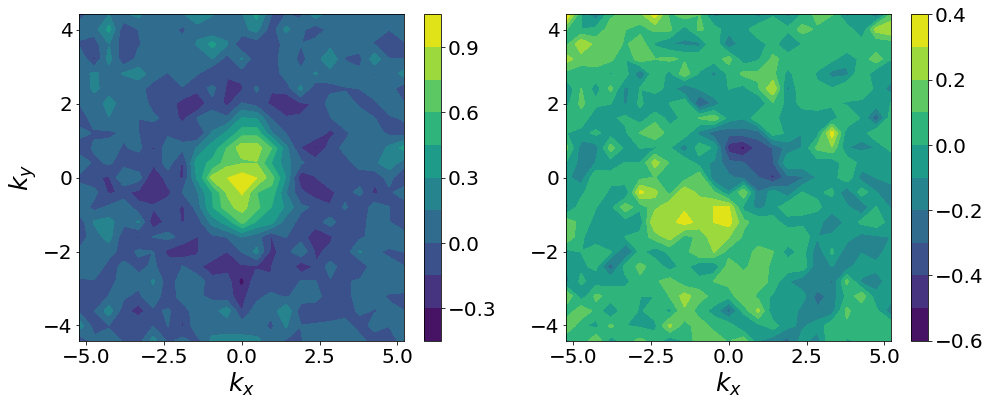

In [41]:
fig, ax = plt.subplots(figsize=(16, 6), ncols=2)
cc = ax[0].contourf(kx, ky, full_cft, 10)
fig.colorbar(cc, ax=ax[0])
sc = ax[1].contourf(kx, ky, full_sft, 10)
fig.colorbar(sc, ax=ax[1])

ax[0].set_xlabel((r"$k_x$"))

ax[0].set_ylabel((r"$k_y$"))

ax[1].set_xlabel((r"$k_x$"))

for c in cc.collections:
    c.set_edgecolor("face")
    
for c in sc.collections:
    c.set_edgecolor("face")

fig.savefig("figures/conical_intersection_raw_data.pdf", bbox_inches='tight')

plt.show()

Here, we rotate by 49 degrees to match the important features of the experiment to that of theory.

In [8]:
full_sft_theta = rotate(full_sft, angle=49)
full_cft_theta = rotate(full_cft, angle=49)

Caclulate rotated axis maximum values.

In [9]:
kx_theta_max = np.abs(np.cos((49/180)*np.pi)*kx[0] + np.sin((49/180)*np.pi)*ky[0])
ky_theta_max = np.abs(np.cos((49/180)*np.pi)*ky[0] + np.sin((49/180)*np.pi)*kx[0])

Text(0.5, 0, '$k_x$')

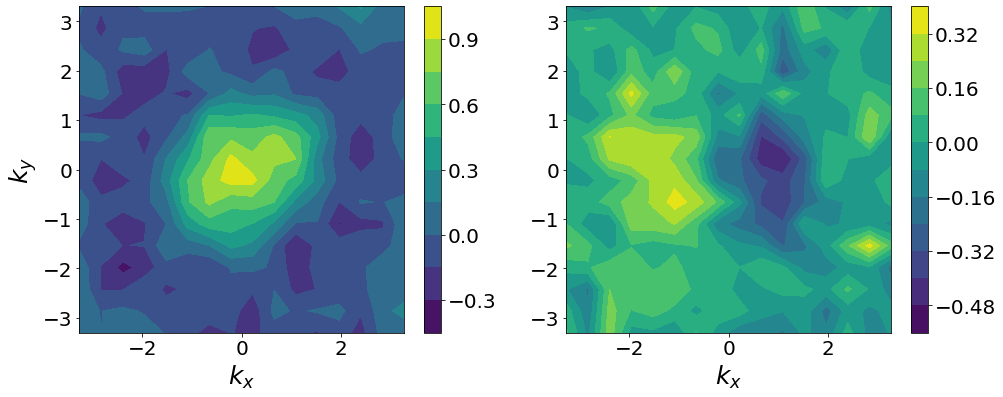

In [10]:
kx_theta = np.linspace(-kx_theta_max, kx_theta_max, len(full_cft_theta))
ky_theta = np.linspace(-ky_theta_max, ky_theta_max, len(full_cft_theta))

fig, ax = plt.subplots(figsize=(16, 6), ncols=2)
cc = ax[0].contourf(kx_theta[8:24], ky_theta[8:24], full_cft_theta[8:24, 8:24], 10)
fig.colorbar(cc, ax=ax[0])
sc = ax[1].contourf(kx_theta[8:24], ky_theta[8:24], full_sft_theta[8:24, 8:24], 10)
fig.colorbar(sc, ax=ax[1])

ax[0].set_xlabel((r"$k_x$"))

ax[0].set_ylabel((r"$k_y$"))

ax[1].set_xlabel((r"$k_x$"))

### 2D Fourier Inverse

Fourier transform performed on k $\approx$ -3.3 to k $\approx$ 3.3 to avoid high frequency features from shot noise.

In [11]:
m = 23
xmax = 2.8
xList = np.linspace(-xmax, xmax, m)
yList = np.linspace(-xmax, xmax, m)

In [12]:
def cft_2d(k_x, k_y, f, x_mat, y_mat):
    total_mat = k_x*x_mat + k_y*y_mat
    f_int = np.exp(-1j*total_mat)*f/2/np.pi
    result = np.trapz(np.trapz(f_int, x=np.transpose(x_mat)[0]), x=y_mat[0]) 
    return result

In [13]:
f =  full_cft_theta[8:24, 8:24] + 1.j*full_sft_theta[8:24, 8:24]

In [14]:
result_2d = np.zeros([m, m], dtype=complex)
kxList = kx_theta[8:24]
kyList = ky_theta[8:24]

kx_mat = np.zeros([len(kxList), len(kxList)])
for i in range(len(kxList)):
        for j in range(len(kxList)):
            kx_mat[i][j] = kxList[i]
            
ky_mat = np.zeros([len(kyList), len(kyList)])
for i in range(len(kyList)):
        for j in range(len(kyList)):
            ky_mat[i][j] = kyList[j]

for i in tqdm(range(m)):
    for j in range(m):
        result_2d[i][j] = cft_2d(xList[i], yList[j], f, kx_mat, ky_mat)

100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 416.23it/s]


### Raw Final Results

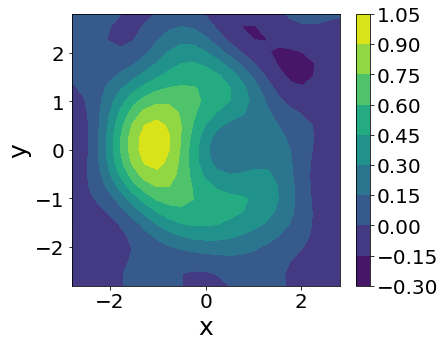

In [15]:
fig, ax = plt.subplots(figsize=(6, 5), ncols=1)
cc = ax.contourf(yList, xList, np.real(result_2d), 10)
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.colorbar(cc, ax=ax)

### Classical Simulation

Classical simulation to compare to, using roughly the same parameters.  The evolution is not Trotterized, although the adiabatic increase in power of the laser interactions is discretized.

In [16]:
from qutip import *
import numpy as np
import os
import matplotlib.pyplot as plt
from math import factorial
from scipy.optimize import fsolve

In [17]:
import sys

sys.path.append("python_scripts")

from hamiltonian_util import *
from spatial_util import *
from wigner_util import *

In [18]:
N = 16
x = np.sqrt(0)
epsilon_x = 3e3
epsilon_y = 3e3
rabi_x_x = 6.8e3*0.97/1.1
rabi_y_y = 6.8e3*0.97/1.1
delta_z = 0e3
sqrt_gamma_x = np.sqrt(0)
sqrt_gamma_y = np.sqrt(0)
sqrt_gamma_phase = np.sqrt(0)
num_steps = 64
exp_time = 0.02
granularity = 2
tau = 5e-3

In [19]:
# Motional operators
a = destroy(N)
iden_N = identity(N)

# Hamiltonians
HO_X, HO_Y, JT_X, JT_Y, H_Z = get_default_hamiltonian_one_ion(N, epsilon_x, epsilon_y, rabi_x_x, rabi_y_y, delta_z)

JT_PX = -1.j*np.pi*rabi_x_x*tensor(a.dag() - a, iden_N, identity(2))

L = tensor(a + a.dag(), -1.j*(a - a.dag()), identity(2)) - tensor(-1.j*(a - a.dag()), a + a.dag(), identity(2))
H_L = (2*np.pi*delta_z/2)*L

JT = rabi_x_x*np.pi*(tensor((a + a.dag())**2, identity(N), identity(2)) + tensor(identity(N), (a + a.dag())**2, identity(2))).sqrtm()

In [20]:
# Jump Operators
jump_operators = get_jump_operators_one_ion(N, sqrt_gamma_x, sqrt_gamma_y, sqrt_gamma_phase)

In [21]:
Hamiltonians = list()
for l in range(64):
    Hamiltonians.append([HO_X, HO_Y, [JT_X + JT_Y + H_Z, f't/{tau}']]) 

times = list()
for l in range(64):
    times.append(np.linspace(l*tau/64, (l+1)*tau/64, 25))


t_total = np.linspace(0, tau, 1600)

In [22]:
plus = (1/np.sqrt(2))*(basis(2, 0) + basis(2, 1))
psi0 = tensor(tensor(thermal_dm(N, 0), thermal_dm(N, 0)), plus*plus.dag())

In [23]:
# Perform eovlutio
states = evolution_by_steps(times, Hamiltonians, psi0, jump_operators)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [24]:
Position_x = tensor(tensor(position(N), identity(N)), identity(2))
sig_x = tensor(tensor(identity(N), identity(N)), sigmax())        
        
x_pos, sig_x_exp = get_expectations(states, [Position_x, sig_x])

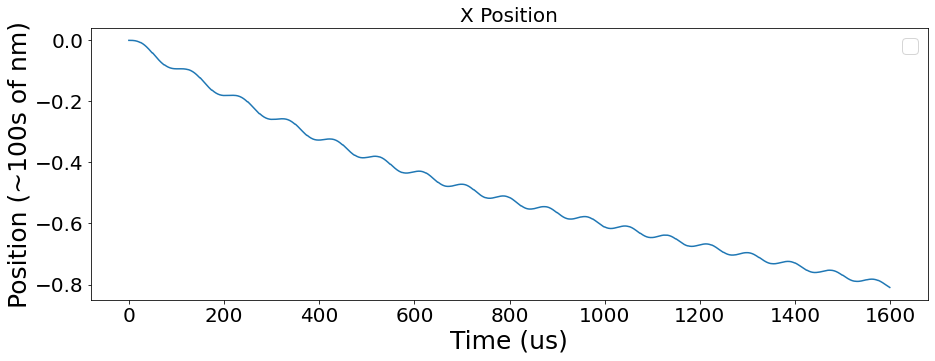

In [25]:
# Plot X Position
fig, axis = plt.subplots(1, 1, figsize=(15, 5))
axis.plot(x_pos)
axis.set_title("X Position")
axis.set_xlabel("Time (us)")
axis.set_ylabel("Position (~100s of nm)")
axis.legend()

In [26]:
xvec = np.linspace(-xmax, xmax, 101)
overall_probs_2 = get_2d_spatial_distribution(states[-1].ptrace([0,1]), N, xvec)

### Final Simulation Results

C:\Users\12482\miniconda3\lib\site-packages\numpy\ma\core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


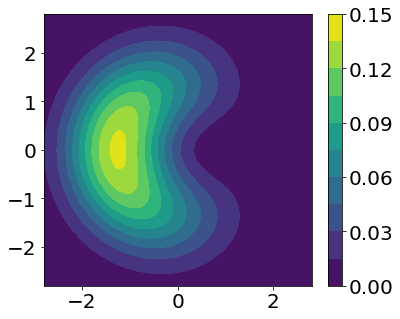

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5))
cc = axes.contourf(xvec, xvec, overall_probs_2/(np.sum(overall_probs_2)*(2*xmax/100)**2), 12)
fig.colorbar(cc, ax=axes)

### Comparison to Normalized Experimental Results

C:\Users\12482\miniconda3\lib\site-packages\numpy\ma\core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


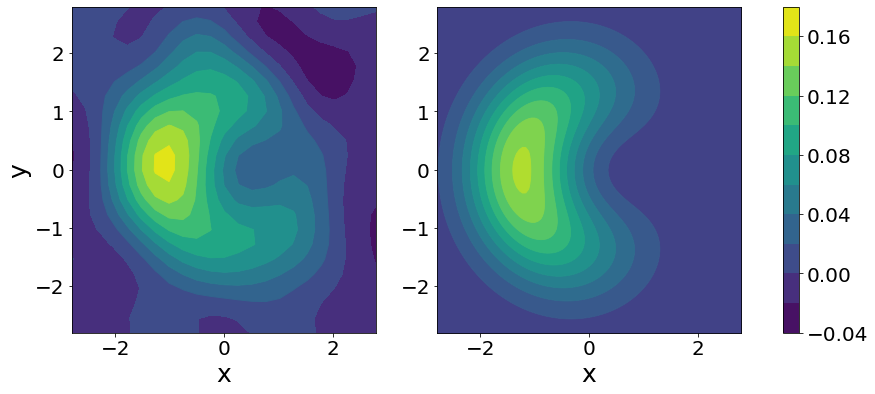

In [40]:
norm_results = np.real(result_2d)/(np.sum(np.real(result_2d))*(2*xmax/(m-1))**2)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
cc = ax[0].contourf(yList, xList, norm_results, 12)
fig.colorbar(cc, ax=ax)

cnt = ax[1].contourf(xvec, xvec, overall_probs_2/(np.sum(overall_probs_2)*(2*xmax/100)**2), 12, 
               vmin=np.min(norm_results), vmax=np.max(norm_results))

ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].set_xlabel("x")

cbar = fig.colorbar(cc, ax=axes)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.tick_params(labelsize=15)

for c in cc.collections:
    c.set_edgecolor("face")
    
for c in cnt.collections:
    c.set_edgecolor("face")

fig.savefig("figures/exp_data_vs_sim.pdf", bbox_inches='tight')

plt.show()

### Simulate Fourier Push

Simulate the push on the classically simulated data, then compare to above distribution.

In [29]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, dct, idct, dst, idst, fft2, ifft2
from tqdm import tqdm

In [30]:
nMax = N
obs_2d = tensor(sigmaz(), qeye(nMax), qeye(nMax))
x = position(nMax)
phi_z = fock(2, 0)
phi_y = (fock(2, 0)+1j*fock(2, 1)).unit()

In [31]:
def push_2d(k_x, k_y, phase_b):
    push = (-1j*tensor(sigmap(), k_x*tensor(a, qeye(nMax)) + k_x*tensor(a.dag()*np.exp(-1.j*phase_b), qeye(nMax)) + \
                       k_y*tensor(qeye(nMax), a) + k_y*tensor(qeye(nMax), a.dag()*np.exp(-1.j*phase_b)))/np.sqrt(8) - \
            1j*tensor(sigmam(), k_x*tensor(a.dag(), qeye(nMax)) + k_x*tensor(a*np.exp(1.j*phase_b), qeye(nMax)) + \
                       k_y*tensor(qeye(nMax), a.dag()) + k_y*tensor(qeye(nMax), a*np.exp(1.j*phase_b)))/np.sqrt(8)).expm()
    return push

In [32]:
def meas_2d(k_x, k_y, phi_m, phase_b):
    push = push_2d(k_x, k_y, phase_b)
    if phi_m.type == 'ket':
        phi = ket2dm(phi_m)
    else:
        phi = phi_m
    phi_c = tensor(ket2dm(phi_z), phi)
    phi_s = tensor(ket2dm(phi_y), phi)
    
    obs = push.dag()*obs_2d*push
    return [expect(obs, phi_c), expect(obs, phi_s)]

In [33]:
sample = 101
kxList = np.linspace(kx_theta[0], kx_theta[-1], sample)
kyList = np.linspace(ky_theta[0], ky_theta[-1], sample)

In [34]:
c = np.zeros([sample, sample], dtype=complex)
s = np.zeros([sample, sample], dtype=complex)

phi_mm = states[-1].ptrace([0,1])
phase_b = np.pi*(-0/180)

for i in tqdm(range(sample)):
    for j in range(sample):
        k_x = kxList[i]
        k_y = kyList[j]

        result = meas_2d(k_x, k_y, phi_mm, phase_b)
        
        c[i][j] = result[0]
        s[i][j] = result[1]

100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [1:08:58<00:00, 40.97s/it]


Here are the cosine (right) and sine (left) portions of the Fourier transform of the simulated spatial distribution.  In comparision to experiment (near the top of the notebook), we see a similar Gaussian pattern with a dip on the edges for the cosine part, and a perfectly assymetric distribution with two Gaussian like bumps in the sine part.

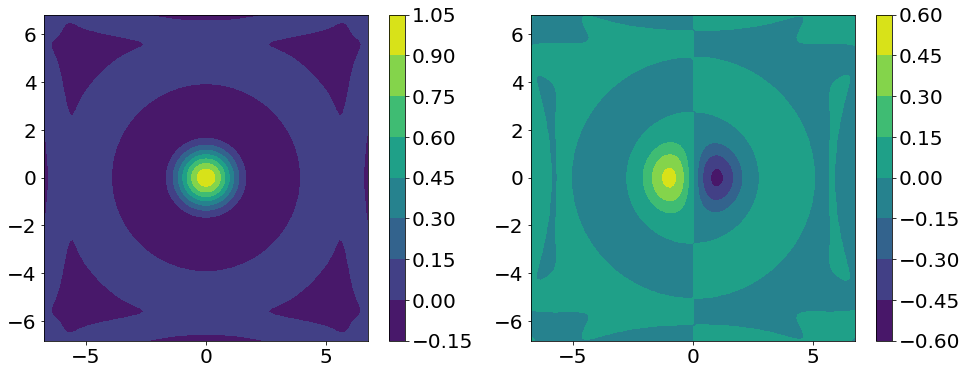

In [35]:
fig, ax = plt.subplots(figsize=(16, 6), ncols=2)
cc = ax[0].contourf(kxList, kyList, np.transpose(np.real(c)), 7)
fig.colorbar(cc, ax=ax[0])
sc = ax[1].contourf(kxList, kyList, np.transpose(np.real(s)), 7)
fig.colorbar(sc, ax=ax[1])

Here we have a direct comparison between theory (blue) and experiment (orange) along a cutout of the most prominent features.  The red dashed lines indicates the bands of shot noise for the $\langle \sigma_z \rangle = 0$ point, when it is the largest.  Each of the distributions approach this value as we move outward, so we cutoff at $k \approx 3.3$ to avoid high frequency noise.

C:\Users\12482\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\12482\miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


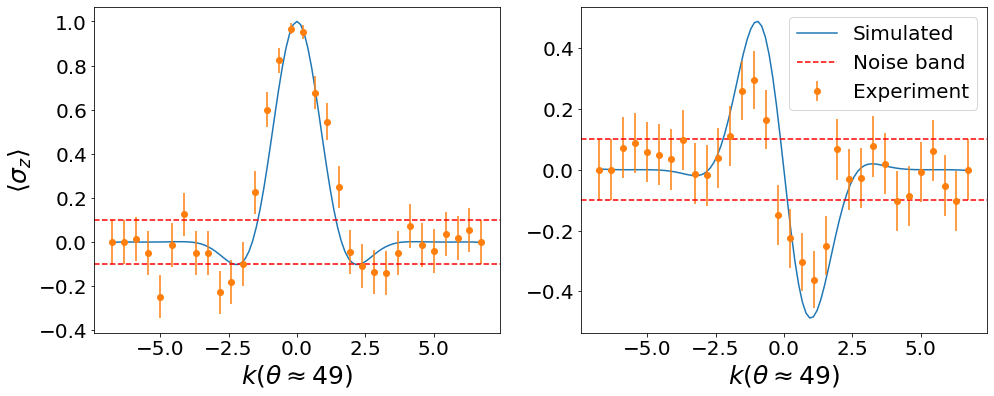

In [36]:
fig, ax = plt.subplots(figsize=(16, 6), ncols=2)

ax[0].plot(kxList, c[int(len(c)/2)], label='Simulated')
ax[0].set_ylabel(r"$\langle \sigma_z \rangle$")
ax[0].set_xlabel(r"$k(\theta \approx 49)$")

pop = ((full_cft_theta)[int(len(full_cft_theta)/2) - 1] + 1)/2
yerr = np.sqrt(pop*(1 - pop)/100)*2

ax[0].errorbar(kx_theta, (full_cft_theta)[int(len(full_cft_theta)/2) - 1], yerr=yerr, label='Experiment', marker='o', linestyle='None')

ax[0].axhline(y = 0.1, color = 'r', linestyle = 'dashed') 
ax[0].axhline(y = -0.1, color = 'r', linestyle = 'dashed') 

ax[1].plot(kxList, np.transpose(s)[int(len(s)/2)], label='Simulated')
ax[1].set_xlabel(r"$k(\theta \approx 49)$")

pop = ((full_sft_theta)[int(len(full_sft_theta)/2) - 1] + 1)/2
yerr = np.sqrt(pop*(1 - pop)/100)*2

ax[1].errorbar(kx_theta, (full_sft_theta)[int(len(full_sft_theta)/2) - 1], yerr=yerr, label='Experiment', marker='o', linestyle='None')

ax[1].axhline(y = 0.1, color = 'r', linestyle = 'dashed', label='Noise band') 
ax[1].axhline(y = -0.1, color = 'r', linestyle = 'dashed')
ax[1].legend()

fig.savefig("figures/exp_data_vs_sim_ft_cutout.pdf", bbox_inches='tight')

plt.show()

Now we take the inverse Fourier transform of the simulated push data and compare to the ideal data to show that this method works.

In [37]:
kx_mat = np.zeros([len(kxList), len(kxList)])
for i in range(len(kxList)):
        for j in range(len(kxList)):
            kx_mat[i][j] = kxList[i]
            
ky_mat = np.zeros([len(kyList), len(kyList)])
for i in range(len(kyList)):
        for j in range(len(kyList)):
            ky_mat[i][j] = kyList[j]

In [38]:
m = 101
result_ideal = np.zeros([m, m], dtype=complex)
xmax = 2.8
xList = np.linspace(-xmax, xmax, m)
yList = np.linspace(-xmax, xmax, m)

In [39]:
for i in tqdm(range(m)):
    for j in range(m):
        result_ideal[i][j] = cft_2d(xList[i], yList[j], c + 1.j*s, kx_mat, ky_mat)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:10<00:00, 10.05it/s]


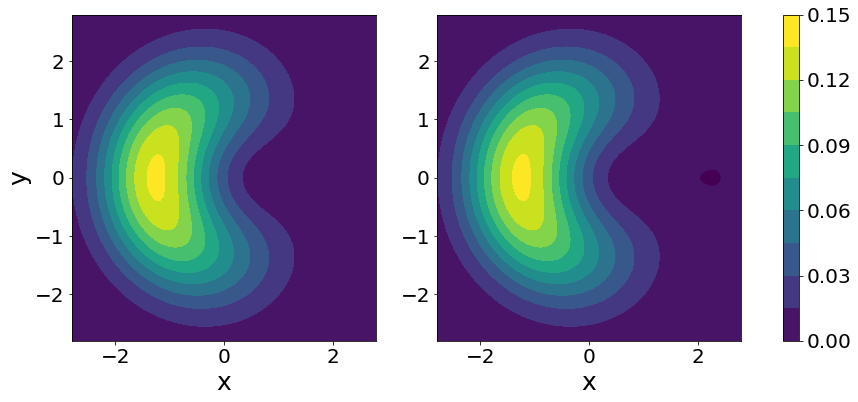

In [40]:
norm_results_ideal = np.real(overall_probs_2/(np.sum(overall_probs_2)*(2*xmax/100)**2))
norm_results_ft = np.real(np.transpose(result_ideal)/(np.sum(result_ideal)*(2*xmax/100)**2))

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
cc = ax[0].contourf(xList, yList, norm_results_ideal, 12, vmin=np.min(norm_results_ideal), vmax=np.max(norm_results_ideal))
fig.colorbar(cc, ax=ax)

ax[1].contourf(xList, yList, norm_results_ft, 12, vmin=np.min(norm_results_ideal), vmax=np.max(norm_results_ideal))

ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].set_xlabel("x")

cbar = fig.colorbar(cc, ax=axes)
ticklabs = cbar.ax.get_yticklabels()
cbar.ax.tick_params(labelsize=15)

###  Fourier Error Bars

Here, we calculate the error bars as they are projected through a Fourier transform.  This is used to calculate the error bars for the ratio plot later on.  Since each of the experiments are identical and independent distributions, there are no covariances on the data, and thus the Fourier transform error bars are simply a Fourier transform of the experimental error bars.

In [29]:
m = 23
result_ideal = np.zeros([m, m], dtype=complex)
xmax = 2.8
xList = np.linspace(-xmax, xmax, m)
yList = np.linspace(-xmax, xmax, m)

In [30]:
pop_cft_2d = (full_cft_theta[8:24, 8:24] + 1)/2
cft_err = np.sqrt(pop_cft_2d*(1 - pop_cft_2d)/100)*2

pop_sft_2d = (full_sft_theta[8:24, 8:24] + 1)/2
sft_err = np.sqrt(pop_sft_2d*(1 - pop_sft_2d)/100)*2

err = cft_err + 1.j*sft_err

In [31]:
errors_2d = np.zeros([m, m], dtype=complex)
kxList = kx_theta[8:24]
kyList = ky_theta[8:24]
kx_mat = np.zeros([len(kxList), len(kxList)])
for i in range(len(kxList)):
        for j in range(len(kxList)):
            kx_mat[i][j] = kxList[i]
            
ky_mat = np.zeros([len(kyList), len(kyList)])
for i in range(len(kyList)):
        for j in range(len(kyList)):
            ky_mat[i][j] = kyList[j]

for i in tqdm(range(m)):
    for j in range(m):
        errors_2d[i][j] = cft_2d(xList[i], yList[j], err, kx_mat, ky_mat)

100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 310.36it/s]


Error bars are normalized in the same way as the original data

C:\Users\12482\miniconda3\lib\site-packages\numpy\ma\core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


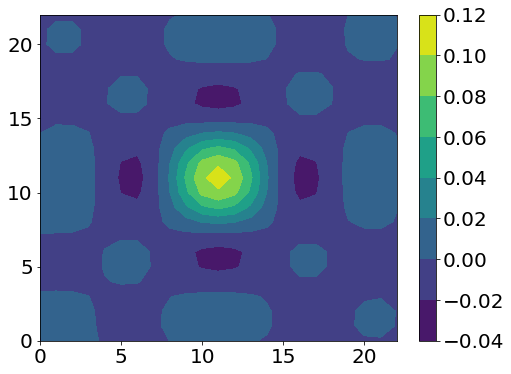

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
cc = ax.contourf(errors_2d/(np.sum(np.real(result_2d))*(2*xmax/(m-1))**2), 7)
fig.colorbar(cc, ax=ax)

### Ratios

Now we calculate the ratio of distribution on one sideo of the plot to the other.  The line that divides the plot in half is rotated from -90 degrees to 90 degrees.  The ratios for experiment are compared to that of simulation.  Error bars are calculated based on the error bars for the inverse Fourier transform above, then a Taylor expansion is taken to first order for the ratio:

$R = \frac{P_+(x,y) \pm \Sigma_+(x, y)}{P_-(x,y) \pm \Sigma_-(x, y)} \approx \frac{P_+(x,y) \pm \Sigma_+(x, y)}{P_-(x,y)}(1 \mp \frac{\Sigma_-(x, y)}{P_-(x,y)}) \approx \frac{P_+(x,y)}{P_-(x,y)} \pm (\frac{\Sigma_+(x, y)}{P_-(x,y)} + \frac{P_+(x,y)\Sigma_-{\theta}(x,y)}{P_-(x,y)^2})$

Here, $P_{\pm}$ is shortand for the integral over the positive/negative side of the dividing line, and $\Sigma_{\pm}$ is the accompanying standard deviation.

In [33]:
error_sums_minus = []
error_sums_plus = []
exp_errors = np.real(errors_2d)/(np.sum(result_2d)*(2*xmax/(m-1))**2)
thetas = np.linspace(-90, 90, 21)
for theta in thetas:
    exp_errors_theta = rotate(exp_errors, angle=theta)
    p_half = np.sum(np.abs(exp_errors_theta[:, int(len(exp_errors_theta[0])/2):]))*(2*xmax/(m-1))**2
    m_half = np.sum(np.abs(exp_errors_theta[:, :int(len(exp_errors_theta[0])/2)]))*(2*xmax/(m-1))**2
    error_sums_plus.append(p_half)
    error_sums_minus.append(m_half)

In [34]:
exp_ratios = []
exp_positive = []
exp_negative = []
exp_data = np.real(result_2d)
thetas = np.linspace(-90, 90, 21)
for theta in thetas:
    exp_data_theta = rotate(exp_data, angle=theta)
    p_half = np.sum(np.real(exp_data_theta[:, int(len(exp_data_theta[0])/2):]))*(2*xmax/(m-1))**2
    m_half = np.sum(np.real(exp_data_theta[:, :int(len(exp_data_theta[0])/2)]))*(2*xmax/(m-1))**2
    exp_ratios.append(p_half/m_half)
    exp_negative.append(m_half)
    exp_positive.append(p_half)

In [35]:
sim_ratios = []
sim_data = overall_probs_2
thetas_sim = np.linspace(-90, 90, 21)
for theta in thetas_sim:
    sim_data_theta = rotate(sim_data, angle=theta)
    p_half = np.sum(np.real(sim_data_theta[:, int(len(sim_data_theta[0])/2):]))
    m_half = np.sum(np.real(sim_data_theta[:, :int(len(sim_data_theta[0])/2)]))
    sim_ratios.append(p_half/m_half)

In [36]:
exp_error_bars = []
for i in range(len(thetas)):
    exp_error_bars.append(exp_positive[i]*error_sums_minus[i]/exp_negative[i]**2 +  error_sums_plus[i]/exp_negative[i])

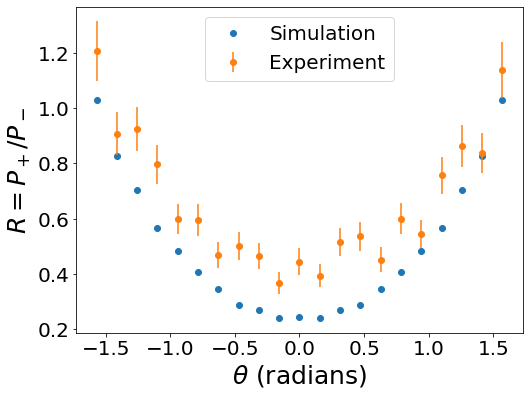

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(thetas_sim*(np.pi/180), sim_ratios, label='Simulation', marker='o', linestyle='None')
ax.errorbar(thetas*(np.pi/180), exp_ratios, yerr=exp_error_bars, label='Experiment', marker='o', linestyle='None')


ax.set_xlabel(r'$\theta$ (radians)')
ax.set_ylabel(r'$R = P_+/P_-$')
ax.legend()

fig.savefig("figures/ratios_with_errors.pdf", bbox_inches='tight')

plt.show()